# EENet and Deep Explain demo

Imports

In [81]:
import mne
import numpy as np
from mne import io
from mne.datasets import sample
import logging
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold

import eegnet

# import tensorflow and disable eager execution right up front
import tensorflow as tf
from tensorflow.keras.metrics import AUC
tf.compat.v1.disable_eager_execution()

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.models import Model

from deepexplain.tf.v2_x import DeepExplain

In [82]:
logger_errors = logging.getLogger('errors')
logger_errors.setLevel(logging.INFO)

## Read data

In [58]:
def read_eeg_data(data_dir_path, case='go_stop'):
    eeg_files = [f for f in os.listdir(data_dir_path) if f.endswith("-full_data.pkl")]

    epochs = []
    labels = []

    for eeg_file in eeg_files:
        try:
            # Path to the epoch file
            data_path = os.path.join(data_dir_path, eeg_file)
            with open(data_path, "rb") as f:
                individual_data_df = pickle.load(f)  # Load events from the pickle file
            print(f"Successfully loaded events from {data_path}")

            if case == 'go_stop':
                individual_epochs = individual_data_df['go_stop_epochs'].to_numpy()
                individual_epochs = np.array([np.array(x) for x in individual_epochs]) 
                logger_errors.info(f"Epochs go-stop shape: {individual_epochs.shape}")
            
            elif case == 'go':
                individual_epochs = individual_data_df['go_epochs'].to_numpy()
                individual_epochs = np.array([np.array(x) for x in individual_epochs]) 
                logger_errors.info(f"Epochs go shape: {individual_epochs.shape}")

            elif case == 'stop':
                individual_epochs = individual_data_df['stop_epochs'].to_numpy()
                individual_epochs = np.array([np.array(x) for x in individual_epochs]) 
                logger_errors.info(f"Epochs stop shape: {individual_epochs.shape}")
            else:
                individual_epochs = None
                logger_errors.info(f"Not recognized case: {case}. Returning None")

            individual_labels = individual_data_df['Trial type'].to_numpy()

            epochs.append(individual_epochs)
            labels.append(individual_labels)        

        except Exception as e:
            logger_errors.info(f"Error processing {eeg_file}: {e}")


    return epochs, labels


def individual_level_train_test_split(X_samples, y_samples, validation_size=5, test_size=0.1):
    dataset_size = len(X_samples)
    test_size_samples = int(test_size * dataset_size)
    train_size_samples = dataset_size - test_size_samples

    # Split data into test and temporary train set
    test_X, test_y = X_samples[:test_size_samples], y_samples[:test_size_samples]
    train_X_tmp, train_y_tmp = X_samples[test_size_samples:], y_samples[test_size_samples:]

    assert len(test_X) + len(train_X_tmp) == dataset_size, "Mismatch in dataset split."

    # Determine validation set size
    validation_size_samples = (
        validation_size if isinstance(validation_size, (int, np.integer)) 
        else int(train_size_samples * validation_size)
    )

    validation_X, validation_y = train_X_tmp[:validation_size_samples], train_y_tmp[:validation_size_samples]
    train_X, train_y = train_X_tmp[validation_size_samples:], train_y_tmp[validation_size_samples:]

    assert len(test_X) + len(train_X) + len(validation_X) == dataset_size, "Final dataset sizes don't match original dataset."

    # Convert lists of 3D arrays into a single 3D NumPy array
    train_X = np.concatenate(train_X, axis=0) if train_X else np.empty((0,) + X_samples[0].shape[1:])
    validation_X = np.concatenate(validation_X, axis=0) if validation_X else np.empty((0,) + X_samples[0].shape[1:])
    test_X = np.concatenate(test_X, axis=0) if test_X else np.empty((0,) + X_samples[0].shape[1:])

    # Convert lists of 1D label arrays into a single 1D NumPy array
    train_y = np.concatenate(train_y) if train_y else np.empty(0, dtype=y_samples[0].dtype)
    validation_y = np.concatenate(validation_y) if validation_y else np.empty(0, dtype=y_samples[0].dtype)
    test_y = np.concatenate(test_y) if test_y else np.empty(0, dtype=y_samples[0].dtype)

    return train_X*1000, train_y, validation_X*1000, validation_y, test_X*1000, test_y


def k_fold_split(X_samples, y_samples, n_splits=5, validation_size=10):
    """
    Perform K-fold cross-validation split without shuffling.
    Ensures each fold is used only once for testing.
    
    Parameters:
    X_samples (list of 3D np.arrays): EEG signal data.
    y_samples (list of 1D np.arrays): Corresponding labels.
    n_splits (int): Number of folds.
    
    Returns:
    Generator yielding train, validation, and test sets for each fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=False)
    
    for train_idx, test_idx in kf.split(X_samples):
        
        # Split into training and test sets
        train_X_tmp = [X_samples[i] for i in train_idx]
        train_y_tmp = [y_samples[i] for i in train_idx]
        test_X = np.concatenate([X_samples[i] for i in test_idx], axis=0)
        test_y = np.concatenate([y_samples[i] for i in test_idx], axis=0)
        
        # Define validation size (10% of training set)
        validation_size = (
            validation_size if isinstance(validation_size, (int, np.integer)) 
            else int(train_size_samples * validation_size)
        )        
        validation_X = np.concatenate(train_X_tmp[:validation_size], axis=0)
        validation_y = np.concatenate(train_y_tmp[:validation_size], axis=0)
        train_X = np.concatenate(train_X_tmp[validation_size:], axis=0)
        train_y = np.concatenate(train_y_tmp[validation_size:], axis=0)
        
        yield train_X * 1000, train_y, validation_X * 1000, validation_y, test_X * 1000, test_y


def score_model(fittedModel, X_test, y_test):
    # Predict class probabilities on the test set
    y_pred_probs = fittedModel.model.predict(X_test)
    
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)  # For categorical labels
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test  # Handle one-hot encoding
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    num_classes = conf_matrix.shape[0]  # Get number of classes

    print(f"ACC: {accuracy_score(y_true, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred)}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Create confusion matrix plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    
    # Add text annotations for TP, TN, FP, FN (only for binary classification)
    if num_classes == 2:
        labels = np.array([["TN", "FP"], ["FN", "TP"]])
        for i in range(2):
            for j in range(2):
                ax.text(j + 0.5, i + 0.5, f"\n({labels[i, j]})", ha='center', va='center', fontsize=12, color='black')
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with TP, TN, FP, FN" if num_classes == 2 else "Confusion Matrix")
    plt.show()

    return accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_pred)


Read EEG data

In [ ]:
data_dir_path = '../final_data/'

X_samples, y_samples = read_eeg_data(data_dir_path = data_dir_path, case='go_stop')

## Define EEGNet model

In [43]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
############################################################################
######## Remember to create and compile model only once in a session #######
############################################################################
dropoutRate = 0.4
kernLength = 64
F1 = 16
D = 2
F2 = 32

model = eegnet.EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = dropoutRate, kernLength = kernLength, F1 = F1, D = D, F2 = F2, 
               dropoutType = 'Dropout')


# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy', AUC()])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}.
class_weights = {0:1, 1:1}

## Simple fitting

In [47]:
X_train, y_train, X_validate, y_validate, X_test, y_test = individual_level_train_test_split(
    X_samples, 
    y_samples,
    validation_size=10, 
    test_size=0.1
    
)

# convert labels to one-hot encodings.
y_train      = np_utils.to_categorical(y_train)
y_validate   = np_utils.to_categorical(y_validate)
y_test       = np_utils.to_categorical(y_test)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 64 channels and 114 time-points. Set the number of kernels to 1.
kernels, chans, samples = 1, 64, 114

X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_validate.shape[0], 'validation samples')

X_train shape: (11666, 64, 114, 1)
11666 train samples
1347 test samples
546 validation samples


In [ ]:
fittedModel = model.fit(X_train, y_train, batch_size = 32, epochs = 50, 
                        verbose = 2, validation_data=(X_validate, y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

2025-03-31 16:39:22.502699: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_10/Assign' id:9706 op device:{requested: '', assigned: ''} def:{{{node true_positives_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_10, true_positives_10/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       646
           1       0.65      0.62      0.63       701

    accuracy                           0.63      1347
   macro avg       0.63      0.63      0.62      1347
weighted avg       0.63      0.63      0.63      1347



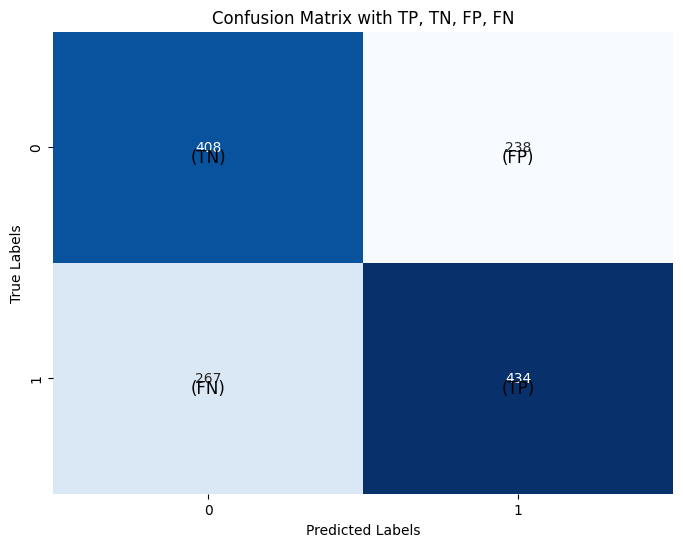

In [45]:
score_model(fittedModel, X_test, y_test)

## Cross-validation results


Fold 1
Train on 11903 samples, validate on 274 samples


2025-04-01 14:36:27.357555: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_47/Assign' id:46343 op device:{requested: '', assigned: ''} def:{{{node true_positives_47/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_47, true_positives_47/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.69560, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11903/11903 - 18s - loss: 0.6883 - accuracy: 0.5431 - auc_47: 0.5623 - val_loss: 0.6956 - val_accuracy: 0.4526 - val_auc_47: 0.4869 - 18s/epoch - 1ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.69560 to 0.68101, saving model to /tmp/checkpoint.h5
11903/11903 - 13s - loss: 0.6816 - accuracy: 0.5629 - auc_47: 0.5874 - val_loss: 0.6810 - val_accuracy: 0.5547 - val_auc_47: 0.5847 - 13s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.68101 to 0.68085, saving model to /tmp/checkpoint.h5
11903/11903 - 14s - loss: 0.6770 - accuracy: 0.5708 - auc_47: 0.6027 - val_loss: 0.6808 - val_accuracy: 0.5657 - val_auc_47: 0.5970 - 14s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss did not improve from 0.68085
11903/11903 - 14s - loss: 0.6756 - accuracy: 0.5773 - auc_47: 0.6084 - val_loss: 0.6929 - val_accuracy: 0.5766 - val_auc_47: 0.5667 - 14s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss did not improve from 0.68085
11903/11903 - 14s - loss: 0.6736 - accuracy: 0.5836 - au

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 14:47:55.638395: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_47/Softmax' id:46339 op device:{requested: '', assigned: ''} def:{{{node softmax_47/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_47/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5926193921852387
ROC AUC: 0.5923826352338492

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       671
           1       0.60      0.60      0.60       711

    accuracy                           0.59      1382
   macro avg       0.59      0.59      0.59      1382
weighted avg       0.59      0.59      0.59      1382



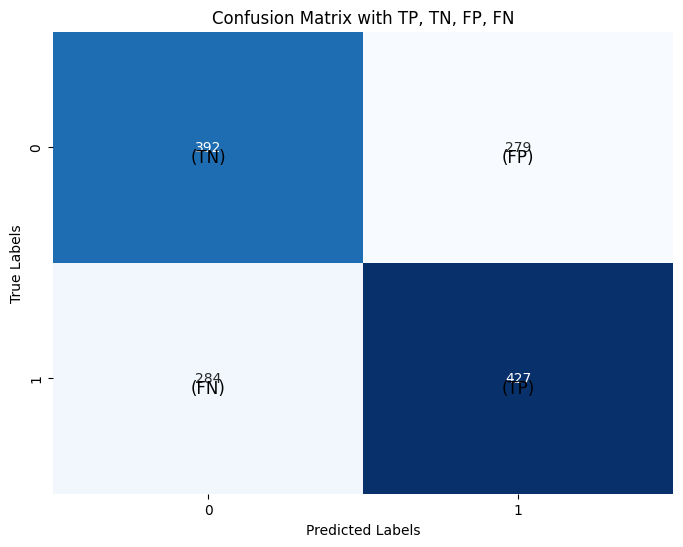


Fold 2
Train on 11860 samples, validate on 313 samples


2025-04-01 14:47:59.509957: W tensorflow/c/c_api.cc:305] Operation '{name:'training_99/Adam/batch_normalization_145/gamma/v/Assign' id:47834 op device:{requested: '', assigned: ''} def:{{{node training_99/Adam/batch_normalization_145/gamma/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_99/Adam/batch_normalization_145/gamma/v, training_99/Adam/batch_normalization_145/gamma/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.67936, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11860/11860 - 18s - loss: 0.6897 - accuracy: 0.5381 - auc_48: 0.5574 - val_loss: 0.6794 - val_accuracy: 0.6262 - val_auc_48: 0.7234 - 18s/epoch - 1ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.67936 to 0.64167, saving model to /tmp/checkpoint.h5
11860/11860 - 13s - loss: 0.6800 - accuracy: 0.5699 - auc_48: 0.5934 - val_loss: 0.6417 - val_accuracy: 0.6486 - val_auc_48: 0.7221 - 13s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.64167 to 0.60966, saving model to /tmp/checkpoint.h5
11860/11860 - 13s - loss: 0.6773 - accuracy: 0.5772 - auc_48: 0.6036 - val_loss: 0.6097 - val_accuracy: 0.6933 - val_auc_48: 0.7619 - 13s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss did not improve from 0.60966
11860/11860 - 13s - loss: 0.6756 - accuracy: 0.5813 - auc_48: 0.6079 - val_loss: 0.6193 - val_accuracy: 0.6773 - val_auc_48: 0.7544 - 13s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss improved from 0.60966 to 0.60322, saving model to /tmp/checkpoint.h5
11860/11860 - 13

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 14:59:20.822575: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_48/Softmax' id:47358 op device:{requested: '', assigned: ''} def:{{{node softmax_48/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_48/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5757575757575758
ROC AUC: 0.5707778183525484

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.46      0.51       661
           1       0.58      0.68      0.63       725

    accuracy                           0.58      1386
   macro avg       0.57      0.57      0.57      1386
weighted avg       0.57      0.58      0.57      1386



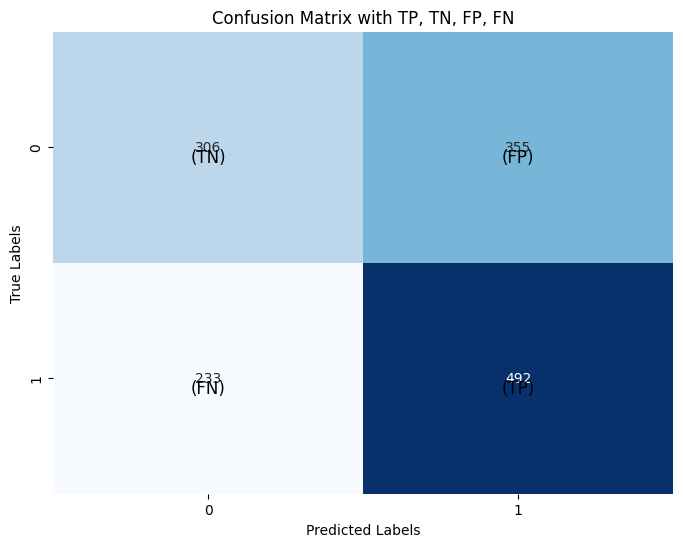


Fold 3
Train on 11840 samples, validate on 313 samples


2025-04-01 14:59:24.382554: W tensorflow/c/c_api.cc:305] Operation '{name:'training_101/Adam/depthwise_conv2d_49/depthwise_kernel/m/Assign' id:48744 op device:{requested: '', assigned: ''} def:{{{node training_101/Adam/depthwise_conv2d_49/depthwise_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_101/Adam/depthwise_conv2d_49/depthwise_kernel/m, training_101/Adam/depthwise_conv2d_49/depthwise_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.67166, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11840/11840 - 18s - loss: 0.6907 - accuracy: 0.5405 - auc_49: 0.5549 - val_loss: 0.6717 - val_accuracy: 0.6486 - val_auc_49: 0.7298 - 18s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.67166 to 0.62828, saving model to /tmp/checkpoint.h5
11840/11840 - 13s - loss: 0.6801 - accuracy: 0.5711 - auc_49: 0.5939 - val_loss: 0.6283 - val_accuracy: 0.7093 - val_auc_49: 0.7610 - 13s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.62828 to 0.61128, saving model to /tmp/checkpoint.h5
11840/11840 - 14s - loss: 0.6771 - accuracy: 0.5758 - auc_49: 0.6033 - val_loss: 0.6113 - val_accuracy: 0.6965 - val_auc_49: 0.7557 - 14s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss did not improve from 0.61128
11840/11840 - 13s - loss: 0.6743 - accuracy: 0.5855 - auc_49: 0.6132 - val_loss: 0.6237 - val_accuracy: 0.6741 - val_auc_49: 0.7225 - 13s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss did not improve from 0.61128
11840/11840 - 13s - loss: 0.6743 - accuracy: 0.5869 - au

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 15:10:44.475816: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_49/Softmax' id:48339 op device:{requested: '', assigned: ''} def:{{{node softmax_49/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_49/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.566145092460882
ROC AUC: 0.5650003162535986

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.55      0.54       639
           1       0.61      0.58      0.59       767

    accuracy                           0.57      1406
   macro avg       0.56      0.57      0.56      1406
weighted avg       0.57      0.57      0.57      1406



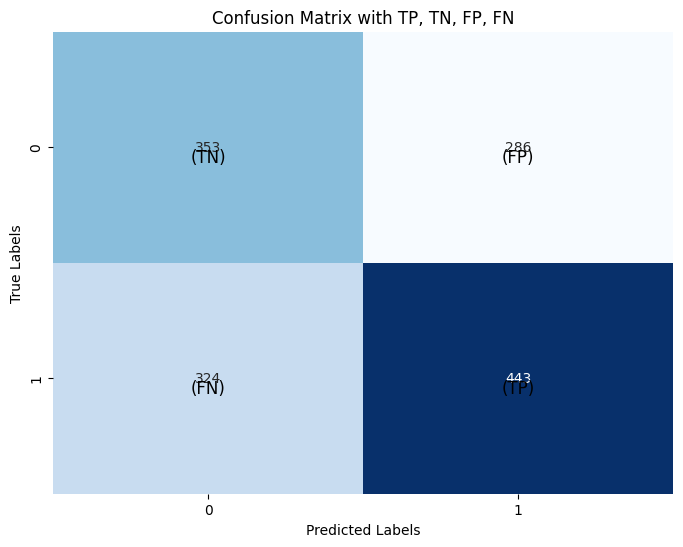


Fold 4
Train on 11873 samples, validate on 313 samples


2025-04-01 15:10:48.016814: W tensorflow/c/c_api.cc:305] Operation '{name:'total_49/Assign' id:49345 op device:{requested: '', assigned: ''} def:{{{node total_49/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_49, total_49/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.67733, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11873/11873 - 18s - loss: 0.6909 - accuracy: 0.5400 - auc_50: 0.5530 - val_loss: 0.6773 - val_accuracy: 0.6901 - val_auc_50: 0.7327 - 18s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.67733 to 0.63843, saving model to /tmp/checkpoint.h5
11873/11873 - 14s - loss: 0.6809 - accuracy: 0.5637 - auc_50: 0.5898 - val_loss: 0.6384 - val_accuracy: 0.6645 - val_auc_50: 0.7328 - 14s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.63843 to 0.61408, saving model to /tmp/checkpoint.h5
11873/11873 - 13s - loss: 0.6790 - accuracy: 0.5745 - auc_50: 0.5977 - val_loss: 0.6141 - val_accuracy: 0.6965 - val_auc_50: 0.7502 - 13s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.61408 to 0.60488, saving model to /tmp/checkpoint.h5
11873/11873 - 13s - loss: 0.6758 - accuracy: 0.5774 - auc_50: 0.6085 - val_loss: 0.6049 - val_accuracy: 0.6901 - val_auc_50: 0.7497 - 13s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss did not improve from 0.60488
11873/11873 - 13

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 15:22:12.415574: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_50/Softmax' id:49320 op device:{requested: '', assigned: ''} def:{{{node softmax_50/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_50/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5775673707210488
ROC AUC: 0.5752520428738194

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.44      0.50       675
           1       0.57      0.71      0.63       698

    accuracy                           0.58      1373
   macro avg       0.58      0.58      0.57      1373
weighted avg       0.58      0.58      0.57      1373



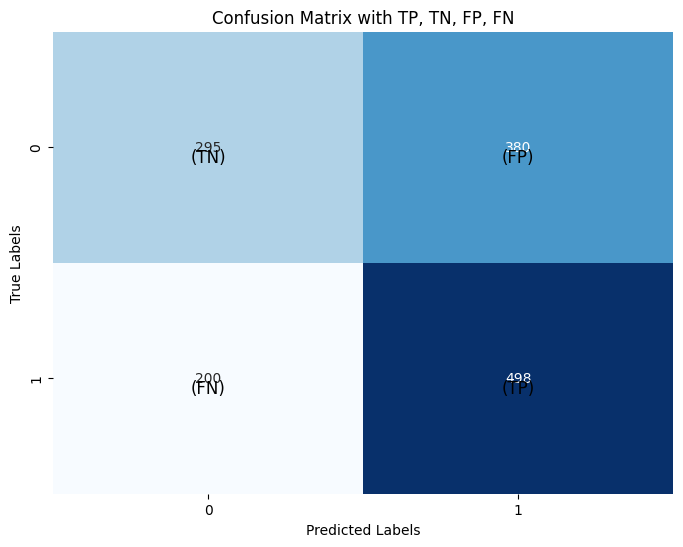


Fold 5
Train on 11824 samples, validate on 313 samples


2025-04-01 15:22:16.137430: W tensorflow/c/c_api.cc:305] Operation '{name:'training_105/Adam/conv2d_51/kernel/m/Assign' id:50689 op device:{requested: '', assigned: ''} def:{{{node training_105/Adam/conv2d_51/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_105/Adam/conv2d_51/kernel/m, training_105/Adam/conv2d_51/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.68210, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11824/11824 - 18s - loss: 0.6910 - accuracy: 0.5344 - auc_51: 0.5505 - val_loss: 0.6821 - val_accuracy: 0.6645 - val_auc_51: 0.7287 - 18s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.68210 to 0.62010, saving model to /tmp/checkpoint.h5
11824/11824 - 13s - loss: 0.6817 - accuracy: 0.5687 - auc_51: 0.5883 - val_loss: 0.6201 - val_accuracy: 0.6965 - val_auc_51: 0.7568 - 13s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss did not improve from 0.62010
11824/11824 - 13s - loss: 0.6783 - accuracy: 0.5760 - auc_51: 0.6008 - val_loss: 0.6301 - val_accuracy: 0.6965 - val_auc_51: 0.7459 - 13s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.62010 to 0.60064, saving model to /tmp/checkpoint.h5
11824/11824 - 13s - loss: 0.6758 - accuracy: 0.5791 - auc_51: 0.6076 - val_loss: 0.6006 - val_accuracy: 0.6869 - val_auc_51: 0.7578 - 13s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss did not improve from 0.60064
11824/11824 - 13s - loss: 0.6729 - accuracy: 0.5823 - au

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 15:33:36.980045: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_51/Softmax' id:50301 op device:{requested: '', assigned: ''} def:{{{node softmax_51/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_51/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5717299578059072
ROC AUC: 0.5693918561183398

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       628
           1       0.62      0.59      0.61       794

    accuracy                           0.57      1422
   macro avg       0.57      0.57      0.57      1422
weighted avg       0.58      0.57      0.57      1422



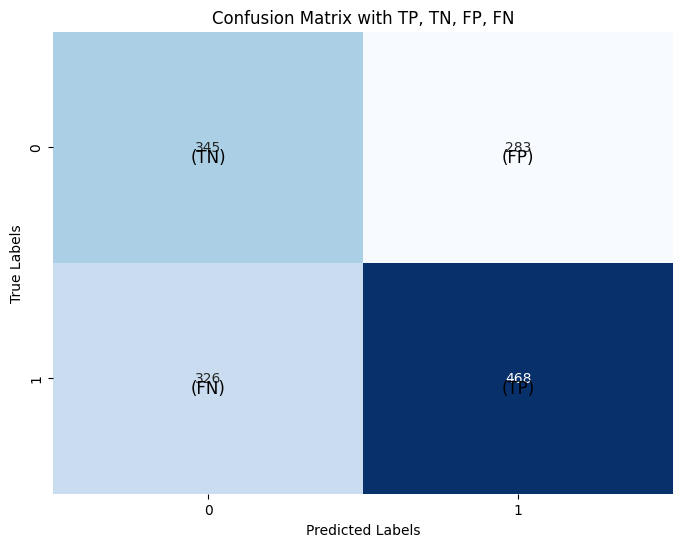


Fold 6
Train on 11907 samples, validate on 313 samples


2025-04-01 15:33:43.112943: W tensorflow/c/c_api.cc:305] Operation '{name:'training_107/Adam/batch_normalization_157/beta/v/Assign' id:51763 op device:{requested: '', assigned: ''} def:{{{node training_107/Adam/batch_normalization_157/beta/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_107/Adam/batch_normalization_157/beta/v, training_107/Adam/batch_normalization_157/beta/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.67515, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11907/11907 - 18s - loss: 0.6876 - accuracy: 0.5511 - auc_52: 0.5646 - val_loss: 0.6752 - val_accuracy: 0.6198 - val_auc_52: 0.7210 - 18s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.67515 to 0.62208, saving model to /tmp/checkpoint.h5
11907/11907 - 14s - loss: 0.6813 - accuracy: 0.5616 - auc_52: 0.5887 - val_loss: 0.6221 - val_accuracy: 0.6773 - val_auc_52: 0.7294 - 14s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.62208 to 0.61894, saving model to /tmp/checkpoint.h5
11907/11907 - 14s - loss: 0.6763 - accuracy: 0.5773 - auc_52: 0.6060 - val_loss: 0.6189 - val_accuracy: 0.6805 - val_auc_52: 0.7480 - 14s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.61894 to 0.60961, saving model to /tmp/checkpoint.h5
11907/11907 - 14s - loss: 0.6755 - accuracy: 0.5776 - auc_52: 0.6071 - val_loss: 0.6096 - val_accuracy: 0.7125 - val_auc_52: 0.7683 - 14s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss improved from 0.60961 to 0.60364, saving mode

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 15:45:07.824889: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_52/Softmax' id:51282 op device:{requested: '', assigned: ''} def:{{{node softmax_52/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_52/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5810306198655714
ROC AUC: 0.5808825497965303

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       672
           1       0.59      0.54      0.56       667

    accuracy                           0.58      1339
   macro avg       0.58      0.58      0.58      1339
weighted avg       0.58      0.58      0.58      1339



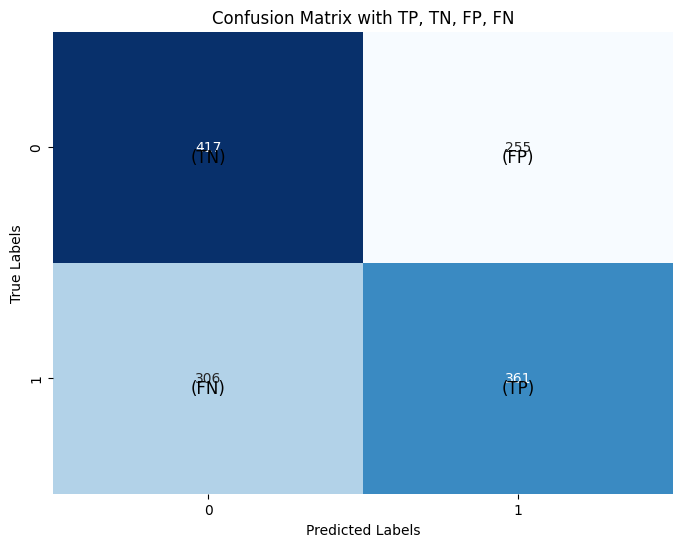


Fold 7
Train on 11855 samples, validate on 313 samples


2025-04-01 15:45:11.626676: W tensorflow/c/c_api.cc:305] Operation '{name:'total_52/Assign' id:52288 op device:{requested: '', assigned: ''} def:{{{node total_52/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_52, total_52/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.66875, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11855/11855 - 18s - loss: 0.6876 - accuracy: 0.5456 - auc_53: 0.5649 - val_loss: 0.6687 - val_accuracy: 0.6454 - val_auc_53: 0.7150 - 18s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.66875 to 0.62063, saving model to /tmp/checkpoint.h5
11855/11855 - 14s - loss: 0.6817 - accuracy: 0.5660 - auc_53: 0.5907 - val_loss: 0.6206 - val_accuracy: 0.7029 - val_auc_53: 0.7526 - 14s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss did not improve from 0.62063
11855/11855 - 13s - loss: 0.6779 - accuracy: 0.5717 - auc_53: 0.6001 - val_loss: 0.6244 - val_accuracy: 0.6741 - val_auc_53: 0.7393 - 13s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.62063 to 0.61062, saving model to /tmp/checkpoint.h5
11855/11855 - 14s - loss: 0.6756 - accuracy: 0.5758 - auc_53: 0.6065 - val_loss: 0.6106 - val_accuracy: 0.6709 - val_auc_53: 0.7438 - 14s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss did not improve from 0.61062
11855/11855 - 13s - loss: 0.6726 - accuracy: 0.5872 - au

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 15:56:33.916246: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_53/Softmax' id:52263 op device:{requested: '', assigned: ''} def:{{{node softmax_53/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_53/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5499640546369519
ROC AUC: 0.5506727107136943

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       671
           1       0.57      0.53      0.55       720

    accuracy                           0.55      1391
   macro avg       0.55      0.55      0.55      1391
weighted avg       0.55      0.55      0.55      1391



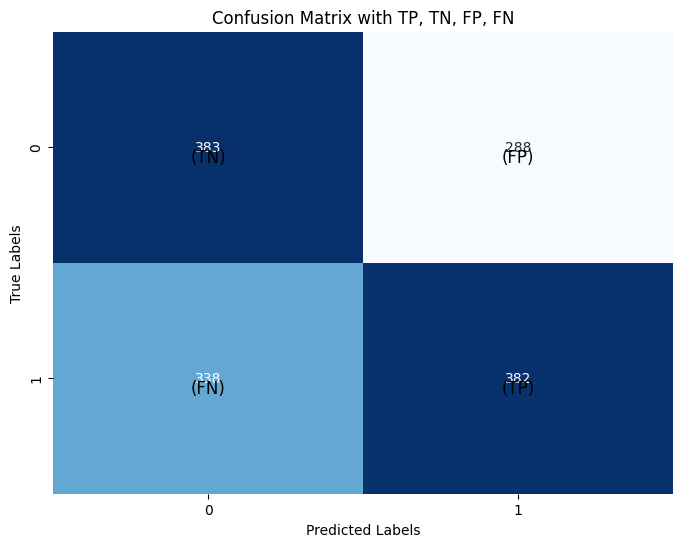


Fold 8
Train on 11954 samples, validate on 313 samples


2025-04-01 15:56:37.808772: W tensorflow/c/c_api.cc:305] Operation '{name:'training_111/Adam/iter/Assign' id:53605 op device:{requested: '', assigned: ''} def:{{{node training_111/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_111/Adam/iter, training_111/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.67452, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11954/11954 - 18s - loss: 0.6898 - accuracy: 0.5405 - auc_54: 0.5553 - val_loss: 0.6745 - val_accuracy: 0.6134 - val_auc_54: 0.6960 - 18s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.67452 to 0.64252, saving model to /tmp/checkpoint.h5
11954/11954 - 14s - loss: 0.6812 - accuracy: 0.5648 - auc_54: 0.5889 - val_loss: 0.6425 - val_accuracy: 0.6645 - val_auc_54: 0.7332 - 14s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.64252 to 0.63544, saving model to /tmp/checkpoint.h5
11954/11954 - 14s - loss: 0.6783 - accuracy: 0.5728 - auc_54: 0.6002 - val_loss: 0.6354 - val_accuracy: 0.6486 - val_auc_54: 0.7076 - 14s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.63544 to 0.62135, saving model to /tmp/checkpoint.h5
11954/11954 - 14s - loss: 0.6755 - accuracy: 0.5786 - auc_54: 0.6090 - val_loss: 0.6213 - val_accuracy: 0.6805 - val_auc_54: 0.7367 - 14s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss improved from 0.62135 to 0.61543, saving mode

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 16:08:08.392156: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_54/Softmax' id:53244 op device:{requested: '', assigned: ''} def:{{{node softmax_54/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_54/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5804953560371517
ROC AUC: 0.5804812212481452

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.58       633
           1       0.59      0.58      0.59       659

    accuracy                           0.58      1292
   macro avg       0.58      0.58      0.58      1292
weighted avg       0.58      0.58      0.58      1292



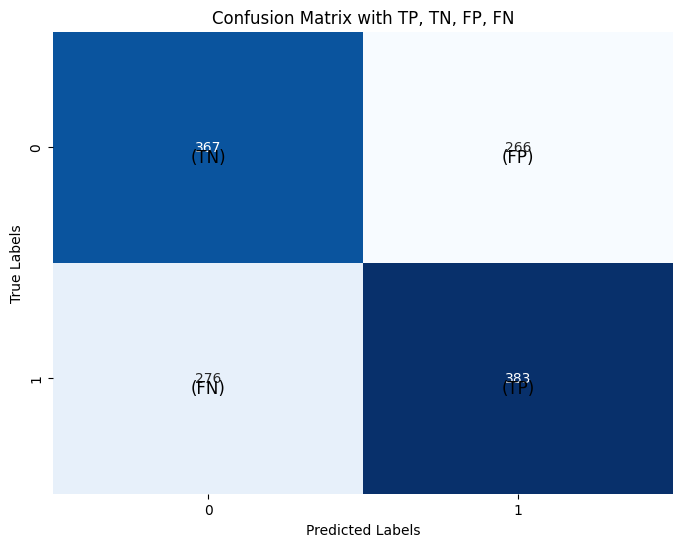


Fold 9
Train on 11908 samples, validate on 313 samples


2025-04-01 16:08:12.212994: W tensorflow/c/c_api.cc:305] Operation '{name:'separable_conv2d_55/pointwise_kernel/Assign' id:54134 op device:{requested: '', assigned: ''} def:{{{node separable_conv2d_55/pointwise_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](separable_conv2d_55/pointwise_kernel, separable_conv2d_55/pointwise_kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.67975, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11908/11908 - 19s - loss: 0.6892 - accuracy: 0.5335 - auc_55: 0.5541 - val_loss: 0.6798 - val_accuracy: 0.6645 - val_auc_55: 0.7455 - 19s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.67975 to 0.63532, saving model to /tmp/checkpoint.h5
11908/11908 - 14s - loss: 0.6812 - accuracy: 0.5675 - auc_55: 0.5901 - val_loss: 0.6353 - val_accuracy: 0.6741 - val_auc_55: 0.7327 - 14s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.63532 to 0.62864, saving model to /tmp/checkpoint.h5
11908/11908 - 14s - loss: 0.6762 - accuracy: 0.5757 - auc_55: 0.6064 - val_loss: 0.6286 - val_accuracy: 0.6837 - val_auc_55: 0.7442 - 14s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.62864 to 0.60166, saving model to /tmp/checkpoint.h5
11908/11908 - 14s - loss: 0.6754 - accuracy: 0.5806 - auc_55: 0.6067 - val_loss: 0.6017 - val_accuracy: 0.6965 - val_auc_55: 0.7548 - 14s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss did not improve from 0.60166
11908/11908 - 14

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 16:19:41.015311: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_55/Softmax' id:54225 op device:{requested: '', assigned: ''} def:{{{node softmax_55/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_55/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5448430493273543
ROC AUC: 0.5451053732303732

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       666
           1       0.55      0.49      0.52       672

    accuracy                           0.54      1338
   macro avg       0.55      0.55      0.54      1338
weighted avg       0.55      0.54      0.54      1338



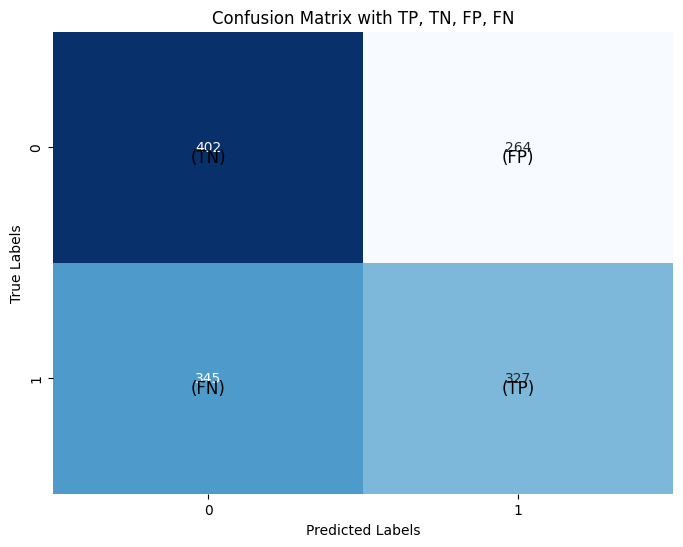


Fold 10
Train on 12016 samples, validate on 313 samples


2025-04-01 16:19:44.910562: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_168/moving_variance/Assign' id:54984 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_168/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_168/moving_variance, batch_normalization_168/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.68659, saving model to /tmp/checkpoint.h5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12016/12016 - 19s - loss: 0.6890 - accuracy: 0.5455 - auc_56: 0.5614 - val_loss: 0.6866 - val_accuracy: 0.6358 - val_auc_56: 0.6941 - 19s/epoch - 2ms/sample
Epoch 2/50

Epoch 2: val_loss improved from 0.68659 to 0.63803, saving model to /tmp/checkpoint.h5
12016/12016 - 14s - loss: 0.6827 - accuracy: 0.5591 - auc_56: 0.5838 - val_loss: 0.6380 - val_accuracy: 0.6837 - val_auc_56: 0.7409 - 14s/epoch - 1ms/sample
Epoch 3/50

Epoch 3: val_loss improved from 0.63803 to 0.62146, saving model to /tmp/checkpoint.h5
12016/12016 - 14s - loss: 0.6787 - accuracy: 0.5733 - auc_56: 0.5975 - val_loss: 0.6215 - val_accuracy: 0.7157 - val_auc_56: 0.7477 - 14s/epoch - 1ms/sample
Epoch 4/50

Epoch 4: val_loss improved from 0.62146 to 0.61066, saving model to /tmp/checkpoint.h5
12016/12016 - 14s - loss: 0.6770 - accuracy: 0.5714 - auc_56: 0.6026 - val_loss: 0.6107 - val_accuracy: 0.7220 - val_auc_56: 0.7660 - 14s/epoch - 1ms/sample
Epoch 5/50

Epoch 5: val_loss improved from 0.61066 to 0.60945, saving mode

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-01 16:31:20.697283: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_56/Softmax' id:55206 op device:{requested: '', assigned: ''} def:{{{node softmax_56/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_56/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


ACC: 0.5934959349593496
ROC AUC: 0.5948679990130767

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       579
           1       0.63      0.57      0.60       651

    accuracy                           0.59      1230
   macro avg       0.59      0.59      0.59      1230
weighted avg       0.60      0.59      0.59      1230



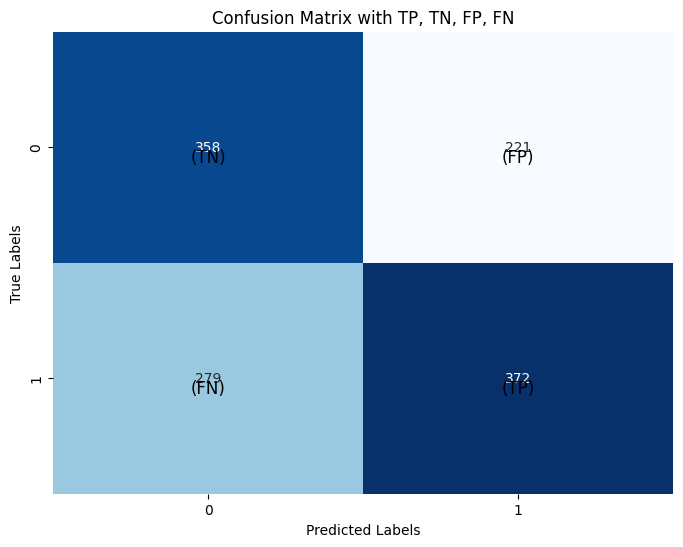

In [83]:
dropoutRate = 0.4
kernLength = 64
F1 = 16
D = 2
F2 = 32

# Iterate through K-Folds
acc_folds = []
roc_folds = []
for fold_idx, (X_train, y_train, X_validate, y_validate, X_test, y_test) in enumerate(k_fold_split(X_samples, y_samples, n_splits=10, validation_size=5)):
    print(f"\nFold {fold_idx + 1}")

    # convert labels to one-hot encodings.
    y_train      = np_utils.to_categorical(y_train)
    y_validate   = np_utils.to_categorical(y_validate)
    y_test       = np_utils.to_categorical(y_test)
    
    # convert data to NHWC (trials, channels, samples, kernels) format. Data 
    # contains 64 channels and 114 time-points. Set the number of kernels to 1.
    kernels, chans, samples = 1, 64, 114
    
    X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

    model = eegnet.EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = dropoutRate, kernLength = kernLength, F1 = F1, D = D, F2 = F2, 
               dropoutType = 'Dropout')


    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics = ['accuracy', AUC()])
    
    # count number of parameters in the model
    numParams    = model.count_params()    
    
    # set a valid path for your system to record model checkpoints
    checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                                   save_best_only=True)

    fittedModel = model.fit(X_train, y_train, batch_size = 32, epochs = 50, 
                        verbose = 2, validation_data=(X_validate, y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

    acc, roc = score_model(fittedModel, X_test, y_test)
    acc_folds.append(acc)
    roc_folds.append(roc)
    

In [85]:
print(f"ACC: {acc_folds}\n Mean: {np.mean(np.array(acc_folds))}")
print(f"ROC AUC: {roc_folds} \n Mean: {np.mean(np.array(roc_folds))}")

ACC: [0.5926193921852387, 0.5757575757575758, 0.566145092460882, 0.5775673707210488, 0.5717299578059072, 0.5810306198655714, 0.5499640546369519, 0.5804953560371517, 0.5448430493273543, 0.5934959349593496]
 Mean: 0.5733648403757031
ROC AUC: [0.5923826352338492, 0.5707778183525484, 0.5650003162535986, 0.5752520428738194, 0.5693918561183398, 0.5808825497965303, 0.5506727107136943, 0.5804812212481452, 0.5451053732303732, 0.5948679990130767] 
 Mean: 0.5724814522833974


In [69]:
np.array([0.6092619392185239, 0.5714285714285714, 0.5547652916073968, 0.58557902403496, 0.5717299578059072, 0.5758028379387603, 0.5449317038102085, 0.565015479876161, 0.5665171898355755, 0.6073170731707317]).mean()

0.5752349068726796

In [70]:
np.array([0.6020260492040521, 0.577922077922078, 0.5533428165007113, 0.5892206846321922, 0.5710267229254571, 0.5675877520537714, 0.5585909417685119, 0.5797213622291022, 0.5657698056801196, 0.5682926829268292]).mean()

0.5733500895842825

In [73]:
np.array([0.5958702064896755, 0.5818713450292398, 0.5501089324618736, 0.5752276867030965, 0.5777182235834609]).mean()

0.5761592788534693

In [ ]:
np.array([0.5958702064896755, 0.5818713450292398, 0.5501089324618736, 0.5752276867030965, 0.5777182235834609]).mean()

In [62]:
print(f"ACC: {acc_folds}\n")
print(f"ROC AUC: {roc_folds})

ACC: [0.6020260492040521, 0.577922077922078, 0.5533428165007113, 0.5892206846321922, 0.5710267229254571, 0.5675877520537714, 0.5585909417685119, 0.5797213622291022, 0.5657698056801196, 0.5682926829268292]

ROC AUC: [0.6046688088605499, 0.5711774218790756, 0.5545721088810132, 0.5893006473522233, 0.5582754416082402, 0.5679860962375956, 0.558498923662858, 0.5808755666467696, 0.5658917846417847, 0.571249492610014]


## Check the performance

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-03-31 16:35:00.995133: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_9/Softmax' id:8721 op device:{requested: '', assigned: ''} def:{{{node softmax_9/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_9/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       646
           1       0.65      0.62      0.63       701

    accuracy                           0.63      1347
   macro avg       0.63      0.63      0.62      1347
weighted avg       0.63      0.63      0.63      1347



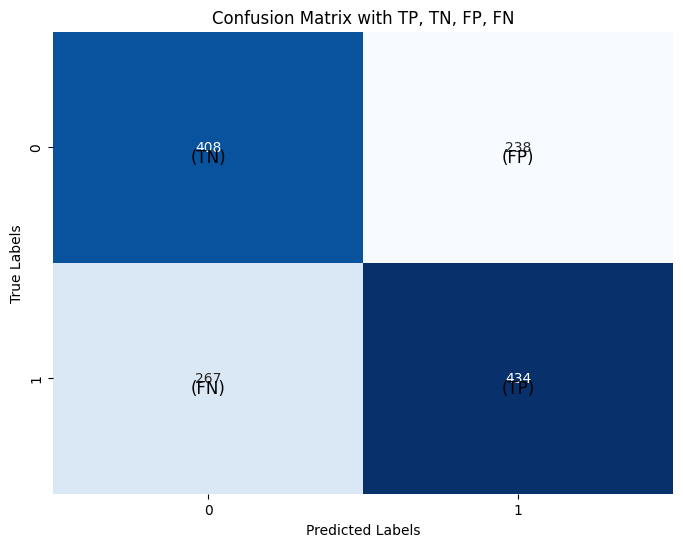

In [42]:
# Predict class probabilities on the test set
y_pred_probs = fittedModel.model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)  # For categorical labels
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test  # Handle one-hot encoding

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
num_classes = conf_matrix.shape[0]  # Get number of classes

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Create confusion matrix plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))

# Add text annotations for TP, TN, FP, FN (only for binary classification)
if num_classes == 2:
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.5, f"\n({labels[i, j]})", ha='center', va='center', fontsize=12, color='black')

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with TP, TN, FP, FN" if num_classes == 2 else "Confusion Matrix")
plt.show()


## Explain the model

In [10]:
with DeepExplain(session = K.get_session()) as de:
	input_tensor   = model.layers[0].input
	fModel         = Model(inputs = input_tensor, outputs = model.layers[-2].output)    
	target_tensor  = fModel(input_tensor)    

	# can use epsilon-LRP as well if you like.
	attributions   = de.explain('deeplift', target_tensor * y_test, input_tensor, X_test)
	# attributions = de.explain('elrp', target_tensor * Y_test, input_tensor, X_test)

/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/deepexplain/tf/v2_x/main.py:97: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


## Plot the results

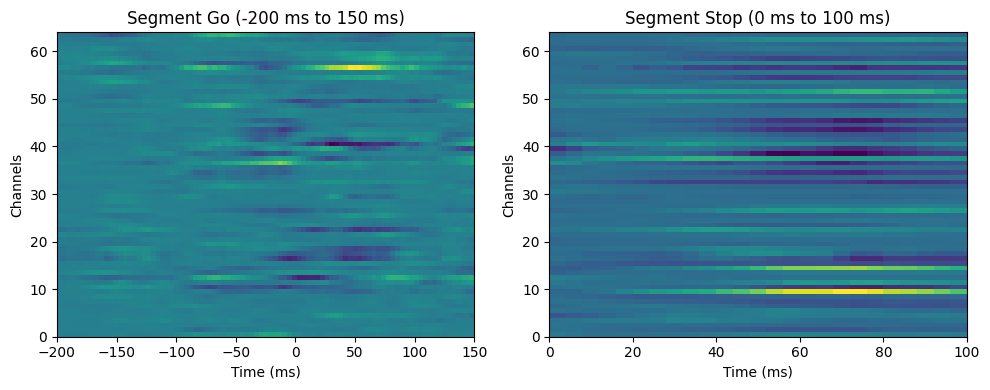

In [29]:
# Define sampling rate
sfreq = 256  # Hz

# Define the number of timepoints in each segment
num_tp_first = 89   # First segment (-200 to 150 ms)
num_tp_second = 25  # Second segment (0 to 100 ms)

# Create the time axis for both segments
first_range = np.linspace(-200, 150, num_tp_first, endpoint=True)  # -200 ms to 150 ms
second_range = np.linspace(0, 100, num_tp_second, endpoint=True)   # 0 ms to 100 ms

# Split the attribution data
attributions_first_segment = attributions[0, :, :num_tp_first].squeeze()  # First segment (0 to 89 timepoints)
attributions_second_segment = attributions[0, :, num_tp_first:].squeeze()  # Second segment (89 to 114 timepoints)

# Plot the first segment (-200 ms to 150 ms)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(attributions_first_segment, aspect="auto", extent=[first_range[0], first_range[-1], 0, attributions.shape[1]])
plt.title('Segment Go (-200 ms to 150 ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Channels')

# Plot the second segment (0 ms to 100 ms)
plt.subplot(1, 2, 2)
plt.imshow(attributions_second_segment, aspect="auto", extent=[second_range[0], second_range[-1], 0, attributions.shape[1]])
plt.title('Segment Stop (0 ms to 100 ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Channels')

# Adjust layout and display
plt.tight_layout()
plt.show()